<a href="https://colab.research.google.com/github/CarolKogei/google-notebooks-dl/blob/main/deepwizard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insect Identification Using Machine Learning

In [ ]:
# Importing the libraries required for the project
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import itertools
import random
import shutil
import glob
import cv2
import os

import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

## Deep Learning

*   Deep learning is a type if machine learning that draws its inspiration from the human brain.
*   It uses artificial neural networks to perform sophisticated computations on large sets of data.
*   Deep learning algorithms train machines by learning from examples.
*   Artificial neural networks are made up of neurons which are also refered to as nodes which are stacked up in three layers namely:
  *   Input layer
  *   Hidden layer
  *   output layer

*   Examples of algorithms that have been utilised in Deep learning are:
  *   Convolutional Neural Networks (CNNs)
  *   Recurremt Neural Networks (RNNs)
  *   Multilayer Perceptrons (MLPs)
  *   Self organisng Maps (SOMs)








## Convolutional Neural Networks (CNNs)


*   A Deep Learning algorithm that was designed for image datasets.
*  Extract features automatically from data with convolution structures.
* It's architecture is inspired by visual perception.
* Artificial neurons correspond to biological neurons.
*CNN kernels represent different kinds of receptors that can respond to various features.
* Activation functions simulate the function that only neural electric signals exceeding a certain threshold can be transmitted to the next neuron.




## Parts of a CNN model

* Convoulution
  * A process in which feature maps are created out of the input data.
  * A function such as ReLU is then applied to filter the maps
* Pooling
  * Responsible for reducing the spatial size of the convolved feature.
  * Reduces the computational power required to process the data
* Flattening the data into a column vector to be fed into a regular neural network for classification
* Fully Connected Layer
  * The model distinguishes between dominating and certain low-level features in images and classify them using the Softmax Classification technique.


In [ ]:
# Mounting google drive on to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# storing paths pointing to the datasets into variables named after the coresponding dataset
train_path = "/content/drive/MyDrive/Colab_Notebooks/beatles/train"
valid_path = "/content/drive/MyDrive/Colab_Notebooks/beatles/validate"
test_path = "/content/drive/MyDrive/Colab_Notebooks/beatles/test"

## Data preparation steps


*  create input data and their corresponding labels data


In [ ]:
# Selecting the top ten species with the highest number of images

keys=df1["insect_gbif"].value_counts()[:10].to_dict().keys()

top_ten="/content/drive/MyDrive/Colab_Notebooks/top_ten/"
os.mkdir(top_ten)
for folder in keys:
  src=path+folder
  shutil.copytree(src,top_ten+folder)
  #print(folder)
  #shutil.rmtree("/content/drive/MyDrive/Colab Notebooks/top_ten")

In [ ]:
# dividing the images into training, testing and validating datasets
database_path = "/content/drive/MyDrive/Colab_Notebooks/top_ten/"
dataset_path = "/content/drive/MyDrive/Colab_Notebooks/beatles/"
species = os.listdir(database_path)
for specie in species:
  imgs = os.listdir(database_path+specie)
  random.shuffle(imgs)
  imgs = imgs[:500] 
  train = imgs[:int(0.7*len(imgs))]
  validate = imgs[int(0.7*len(imgs)):int(0.7*len(imgs)+0.2*len(imgs))]
  test = imgs[int(-0.1*len(imgs)):]
  #print(len(train),len(validate), len(test))

  dataset = [[train, "train"], [validate, "validate"], [test, "test"]]

  #copy files from top_ten dirs to respective dirs
  for folder in dataset:
    os.makedirs(dataset_path+folder[1]+"/"+specie)
    for img in folder[0]:
      source_path = database_path+specie+"/"+img
      dest_path = dataset_path+folder[1]+"/"+specie+"/"+img
      
      shutil.copyfile(source_path, dest_path)

*  convert both the input data and labels data into numpy arrays, tensorflow tensors, `tf.data` datasets, dict mapping input names to corresponding array/tensors a generator or `keras.utils.Sequence`

In [ ]:
# putting the datasets in the format of a keras generator
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes = ["1035185", "1035195", "1035864", "1035931", "1036216", "4474169", "4475140", "5755079", "7508714", "9364935"], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes = ["1035185", "1035195", "1035864", "1035931", "1036216", "4474169", "4475140", "5755079", "7508714", "9364935"], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes = ["1035185", "1035195", "1035864", "1035931", "1036216", "4474169", "4475140", "5755079", "7508714", "9364935"], batch_size=10, shuffle=False)

Found 3500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
print(train_batches[0][1][1][0])

'''for i in train_batches[0]:
  print(i)
  break'''

0.0


'for i in train_batches[0]:\n  print(i)\n  break'

In [ ]:
# verifying that each batch contains the expected number of images
assert train_batches.n == 3500
assert valid_batches.n == 1000
assert test_batches.n == 500
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

In [ ]:
# getting one batch of images and their corresponding labels from the trainng dataset
imgs, labels = next(train_batches)

In [ ]:
# function that plots the images in the form of a grid  with one row and ten columns
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(image_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

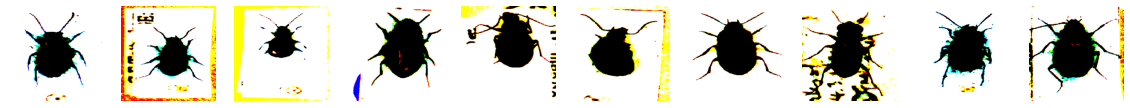

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

## Constructing the model

In [ ]:
# constructing the model 

Name = "Black Beetles"
tensorboard = TensorBoard(log_dir="logs/{}".format(Name))

model = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=2),
                    Flatten(),
                    Dense(units=10, activation='softmax'),
])

In [ ]:
# taking a look at the wummary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [ ]:
# compile the models
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2, callbacks=[tensorboard])

Epoch 1/10
350/350 - 170s - loss: 1.7398 - accuracy: 0.4017 - val_loss: 1.1634 - val_accuracy: 0.6150 - 170s/epoch - 484ms/step
Epoch 2/10
350/350 - 169s - loss: 0.9923 - accuracy: 0.6720 - val_loss: 0.9883 - val_accuracy: 0.6480 - 169s/epoch - 482ms/step
Epoch 3/10
350/350 - 177s - loss: 0.5904 - accuracy: 0.8034 - val_loss: 0.6672 - val_accuracy: 0.7670 - 177s/epoch - 504ms/step
Epoch 4/10
350/350 - 169s - loss: 0.3584 - accuracy: 0.8851 - val_loss: 0.6141 - val_accuracy: 0.8000 - 169s/epoch - 481ms/step
Epoch 5/10
350/350 - 167s - loss: 0.2182 - accuracy: 0.9291 - val_loss: 0.5391 - val_accuracy: 0.8140 - 167s/epoch - 478ms/step
Epoch 6/10
350/350 - 168s - loss: 0.1098 - accuracy: 0.9691 - val_loss: 0.5111 - val_accuracy: 0.8340 - 168s/epoch - 479ms/step
Epoch 7/10
350/350 - 167s - loss: 0.0698 - accuracy: 0.9834 - val_loss: 0.6462 - val_accuracy: 0.8080 - 167s/epoch - 477ms/step
Epoch 8/10
350/350 - 167s - loss: 0.0638 - accuracy: 0.9817 - val_loss: 0.7190 - val_accuracy: 0.7960 - 

In [ ]:
+----------0..............................
import os.path
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/Beetle_ID.h5') is False:
  model.save('/content/drive/MyDrive/Colab Notebooks/models/Beetle_ID.h5')

# Objectives for the week

* Data Augmentation
* Testing parameters hypothesis
* VGG 16 & InceptionNet implementation


## Important figures

* Deep learning model

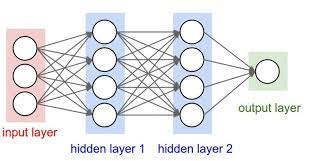


* Convolutional Neural Network

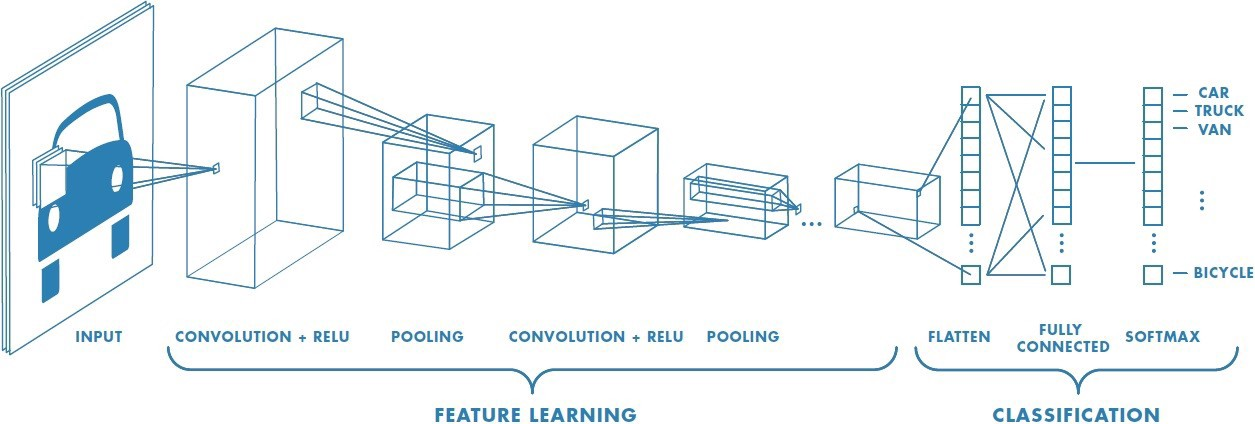

# VGG16 Architecture

## Data Augmentation

* This step is important in making dataset rich and sufficient inorder to get optimal results from the model
* This code simply creates different version of the same picture by rotations, cropping and flipping the image
* We failed get a code that specifies the number of copies per image 

In [ ]:
#data augmentation
#augment= ImageDataGenerator()


train_datagen = ImageDataGenerator(height_shift_range=2, 
                                    shear_range=.28, 
                                   horizontal_flip= True, 
                                   vertical_flip= True, 
                                   channel_shift_range=10, 
                                   zoom_range=0.1, 
                                   rotation_range=20, 
                                   width_shift_range=2, 
                                   brightness_range= [1.0,1.0],
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=10,
    class_mode='categorical',
    classes = ["1035185", "1035195", "1035864", "1035931", "1036216", "4474169", "4475140", "5755079", "7508714", "9364935"])

Found 3500 images belonging to 10 classes.


'for batch in iterator:\n  for i in range(100)\naug_images =[next(iterator) for i in range(100)]'

* Preprocessing validation and test datasets because their images are not augmented

In [ ]:
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes = ["1035185", "1035195", "1035864", "1035931", "1036216", "4474169", "4475140", "5755079", "7508714", "9364935"], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes = ["1035185", "1035195", "1035864", "1035931", "1036216", "4474169", "4475140", "5755079", "7508714", "9364935"], batch_size=10, shuffle=False)

Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


## Feature Transferwith VGG16

**Step 1: Instantiating the model**

In [ ]:
#Downloading the VGG16 pretrained model over the internet
VGG16_model=tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 12s 0us/step


**Step 2: Customising the pre-trained model**

* Create a sequential model
* Using the '.add' method to add layers of the vgg16 pre-trained model except the last output layer

In [ ]:
#Transfering the layers of VGG16 pretrained model into our sequential model
#Excluding the output layer of the VGG16 model
deep_model = Sequential()
for layer in VGG16_model.layers[:-1]:
  deep_model.add(layer)

* Setting the already trained layers to false to maintain the existing weights

In [ ]:
#freezing the pretrained layers so as to leave their weights unaltered
for layer in deep_model.layers:
  layer.trainable=False

* Defining the final output layer with 10 classes for the different species in our datset and adding it to our new sequential model

In [ ]:
#Adding an output layer to our custom model
deep_model.add(Dense(units=10, activation='softmax'))

* A general overview of our model

In [ ]:
deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

**Step 3: Compiling the model**

* using SGD optimizer, categorical crossentropy loss function, accuracy and categorical metrics parameters
* A defined momentum to optimise the learning rate

In [ ]:
deep_model.compile(optimizer=SGD(learning_rate=0.0001, momentum = 0.9), loss=categorical_crossentropy, metrics=['accuracy', 'categorical_accuracy'])

**Step 4: Fitting the model**

In [ ]:
deep_model.fit(x=train_generator, validation_data=valid_batches,epochs=10, verbose=2)

Epoch 1/10
350/350 - 2351s - loss: 1.5391 - accuracy: 0.4880 - categorical_accuracy: 0.4880 - val_loss: 1.0846 - val_accuracy: 0.6280 - val_categorical_accuracy: 0.6280 - 2351s/epoch - 7s/step
Epoch 2/10
350/350 - 2325s - loss: 0.9118 - accuracy: 0.6883 - categorical_accuracy: 0.6883 - val_loss: 0.8036 - val_accuracy: 0.7560 - val_categorical_accuracy: 0.7560 - 2325s/epoch - 7s/step
Epoch 3/10
350/350 - 2332s - loss: 0.7712 - accuracy: 0.7431 - categorical_accuracy: 0.7431 - val_loss: 0.7646 - val_accuracy: 0.7490 - val_categorical_accuracy: 0.7490 - 2332s/epoch - 7s/step
Epoch 4/10
350/350 - 2321s - loss: 0.6791 - accuracy: 0.7669 - categorical_accuracy: 0.7669 - val_loss: 0.7146 - val_accuracy: 0.7700 - val_categorical_accuracy: 0.7700 - 2321s/epoch - 7s/step
Epoch 5/10
350/350 - 2324s - loss: 0.6176 - accuracy: 0.7989 - categorical_accuracy: 0.7989 - val_loss: 0.6842 - val_accuracy: 0.7770 - val_categorical_accuracy: 0.7770 - 2324s/epoch - 7s/step
Epoch 6/10
350/350 - 2331s - loss: 

In [ ]:
#Results from the first test run.
#This run was interupted by loss of connection to google colab
Epoch 1/10
350/350 - 3136s - loss: 1.7002 - accuracy: 0.4189 - val_loss: 1.1556 - val_accuracy: 0.6270 - 3136s/epoch - 9s/step
Epoch 2/10
350/350 - 2338s - loss: 1.0221 - accuracy: 0.6614 - val_loss: 0.8896 - val_accuracy: 0.7310 - 2338s/epoch - 7s/step
Epoch 3/10
350/350 - 2343s - loss: 0.8006 - accuracy: 0.7377 - val_loss: 0.7737 - val_accuracy: 0.7840 - 2343s/epoch - 7s/step
Epoch 4/10
350/350 - 2346s - loss: 0.6759 - accuracy: 0.7849 - val_loss: 0.6979 - val_accuracy: 0.7970 - 2346s/epoch - 7s/step
Epoch 5/10
350/350 - 2329s - loss: 0.6152 - accuracy: 0.8029 - val_loss: 0.6426 - val_accuracy: 0.8110 - 2329s/epoch - 7s/step
Epoch 6/10
350/350 - 2335s - loss: 0.5553 - accuracy: 0.8254 - val_loss: 0.6059 - val_accuracy: 0.8310 - 2335s/epoch - 7s/step
Epoch 7/10
350/350 - 2337s - loss: 0.5250 - accuracy: 0.8286 - val_loss: 0.6246 - val_accuracy: 0.7970 - 2337s/epoch - 7s/step
Epoch 8/10
350/350 - 2350s - loss: 0.4999 - accuracy: 0.8437 - val_loss: 0.5629 - val_accuracy: 0.8270 - 2350s/epoch - 7s/step
Epoch 9/10
350/350 - 2348s - loss: 0.4677 - accuracy: 0.8463 - val_loss: 0.5191 - val_accuracy: 0.8400 - 2348s/epoch - 7s/step
Epoch 10/10

## Inference 

The VGG16 model is a robust model, having been originally trained on the imagenet dataset that contans over 14 million images distributed across 21 thousand categories of images.

Due to this model's robustness, feature transfer to our custom model is relatively easy and convenient, this is more so because we can do as little as retraining the output layer of the VGG16 model on our custom dataset and get outstanding accuracies.
The results obtained by retrainig the output layer on our dataset were great, with a maximun accuracy of 84.6% and validation accuracy of 84% after 9 epochs

**Step 5: Testing the Model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

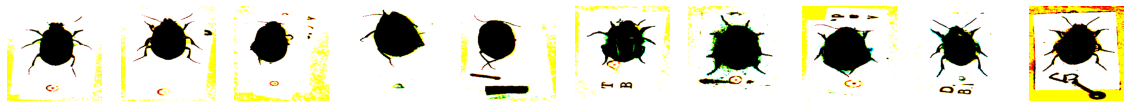

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

In [ ]:
predictions = model.predict(x=test_batches, verbose=2)

50/50 - 105s - 105s/epoch - 2s/step


**Step 6: Confusion matrix**

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [ ]:
def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')
  print(cm)

  thresh = cm.max()/2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

Confusion matrix, without normalization
[[47  0  2  0  0  0  1  0  0  0]
 [ 5 38  0  0  1  0  1  0  2  3]
 [ 2  3 44  0  0  0  1  0  0  0]
 [ 0  1  1 34  9  1  1  0  1  2]
 [ 0  0  0  0 49  0  0  0  0  1]
 [ 0  0  0  3  0 39  4  3  0  1]
 [ 0  0  0  1  0  0 47  0  2  0]
 [ 0  0  0  3  1  0  0 36 10  0]
 [ 0  0  0  3  2  0  0  1 38  6]
 [ 0  0  0  0  1  0  0  0  0 49]]


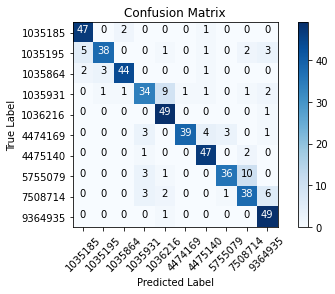

In [ ]:
cm_plot_labels = ["1035185", "1035195", "1035864", "1035931", "1036216", "4474169", "4475140", "5755079", "7508714", "9364935", ]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# constructing the model 

model_2 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
                    MaxPooling2D(pool_size=(2,2), strides=1),
                    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=1),
                    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=1),
                    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=1),
                    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=1),
                    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=1),
                    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPooling2D(pool_size=(2,2), strides=1),
                    Flatten(),
                    Dense(units=10, activation='softmax'),
])

In [ ]:
# compile the models
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
# Train the model
model_2.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(16, (3,3), padding='same', input_shape = (224,224,3)))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Activation("relu"))


model_3.add(Conv2D(32, (3,3), padding='same'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Activation("relu"))


model_3.add(Conv2D(64, (3,3), padding='same'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Activation("relu"))


model_3.add(Conv2D(128, (3,3), padding='same'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Activation("relu"))


model_3.add(Conv2D(256, (3,3), padding='same'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Activation("relu"))


model_3.add(Flatten())

model_3.add(Dense(10))
model_3.add(Activation("softmax"))



In [ ]:
model.summary()

In [ ]:
model_3.compile(loss="categorical_crossentropy" , optimizer="adam", metrics = ["accuracy"])

In [ ]:
model_3.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
350/350 - 247s - loss: 4.0051 - accuracy: 0.1086 - val_loss: 2.3019 - val_accuracy: 0.1040 - 247s/epoch - 706ms/step
Epoch 2/10
350/350 - 246s - loss: 2.2311 - accuracy: 0.1669 - val_loss: 2.1102 - val_accuracy: 0.2170 - 246s/epoch - 703ms/step
Epoch 3/10
350/350 - 245s - loss: 2.1040 - accuracy: 0.2300 - val_loss: 2.0342 - val_accuracy: 0.2570 - 245s/epoch - 701ms/step
Epoch 4/10
350/350 - 243s - loss: 2.0379 - accuracy: 0.2509 - val_loss: 2.0649 - val_accuracy: 0.2510 - 243s/epoch - 695ms/step
Epoch 5/10
350/350 - 245s - loss: 1.7799 - accuracy: 0.3506 - val_loss: 1.5764 - val_accuracy: 0.4300 - 245s/epoch - 701ms/step
Epoch 6/10
350/350 - 243s - loss: 1.4824 - accuracy: 0.4729 - val_loss: 1.4262 - val_accuracy: 0.4920 - 243s/epoch - 694ms/step
Epoch 7/10
350/350 - 242s - loss: 1.2011 - accuracy: 0.5814 - val_loss: 1.2194 - val_accuracy: 0.5720 - 242s/epoch - 692ms/step
Epoch 8/10
350/350 - 242s - loss: 0.9284 - accuracy: 0.6811 - val_loss: 0.9767 - val_accuracy: 0.6530 - 

In [ ]:
np.round(predictions[:10])  

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
test_batches.class_indices

{'1035185': 0,
 '1035195': 1,
 '1035864': 2,
 '1035931': 3,
 '1036216': 4,
 '4474169': 5,
 '4475140': 6,
 '5755079': 7,
 '7508714': 8,
 '9364935': 9}